# Analyzing xkcd's color survey data

Large dataset from a survey where participants had to name colors that were shown to them (main data analyzed here: r,g,b values of the colors and given colorname)
Further description of the dataset and data available at https://blog.xkcd.com/2010/05/03/color-survey-results/
Main goal of this notebook: Reading sql data in, cleaning data (e.g. removing spam), reducing the number of unique colornames

#### 1st step: Creating SQLite database in terminal from colorsurvey data:

sqlite3 mainsurvey.db < mainsurvey_sqldump.txt

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io

Connecting to the database:

In [2]:
conn = sql.connect('data/colorsurvey/mainsurvey.db')

In [3]:
# show the names of the tables in the database
pd.read_sql_query("select name from sqlite_master where type = 'table';", conn)

,name
0,users
1,answers
2,names


## 1) Reading in the SQL data

In [4]:
# Read the values from all (*) columns of the "answers" table and return max. 5 rows of results
pd.read_sql_query('SELECT * FROM answers LIMIT 5;', conn)

,id,user_id,datestamp,r,g,b,colorname
0,1,1,1.267419e+09,72,100,175,pastel blue
1,2,1,1.267419e+09,204,177,246,faint violet
2,3,1,1.267419e+09,182,226,245,baby blue
3,4,1,1.267419e+09,130,64,234,purple
4,5,2,1.267419e+09,75,49,234,blue


In [5]:
pd.read_sql_query('SELECT * FROM names LIMIT 10;', conn)

,id,colorname,numusers,numinstances
0,1,,81,None
1,2,...,1,None
2,3,...,1,None
3,4,"(o"")",1,None
4,5,"(""o)",1,None
5,6,"(""o)",1,None
6,7,"(o"")",1,None
7,8,>>#,1,None
8,9,>>==n;),1,None
9,10,"(o"")",1,None


In [6]:
# Read the values from all (*) columns of the "users table and return max. 5 rows of results

pd.read_sql_query('SELECT * FROM users LIMIT 5;', conn)

,id,user_key,datestamp,ip,language,monitor,temperature,gamma,colorblind,ychrom,samplecolors,spamprob
0,1,1irzBJF4C4MNNn5H3Ww7SFNRvqSUG,1.267419e+09,0.0.0.0,None,LCD,6500.0,2.2,0,1,blue/royal periwinkle,0.002088
1,2,1hW1tdQ5iCxFnIy4Xpc3ckh18ZDL,1.267419e+09,0.0.0.0,None,LCD,6500.0,NaN,0,1,pink/pale salmon,0.074577
2,3,1GI5SzNKh6ntR5mhD494MkZG0s4Zk1,1.267419e+09,0.0.0.0,None,LCD,NaN,NaN,0,1,green/light olive,0.016404
3,4,18l2GajPo4ptcw1YTXKRm1Xn8jEfNN,1.267419e+09,0.0.0.0,None,LCD,NaN,NaN,0,0,green/light olive,0.001562
4,5,1Qd1F6Oi9B4E6c7xInaDeqIRxmJevx1,1.267419e+09,0.0.0.0,None,LCD,6500.0,2.2,0,1,brown/raw umber,0.002381


In [7]:
users = pd.read_sql_query('SELECT * FROM users;', conn) # shape: 152401,12

In [8]:
users.describe()

,id,datestamp,temperature,gamma,colorblind,ychrom,spamprob
count,152401.000000,1.524010e+05,22535.000000,1.270200e+04,142553.000000,144894.000000,152401.000000
mean,76201.000000,1.268474e+09,6927.375194,7.794048e+44,0.039199,0.713832,0.222319
std,43994.523525,8.580465e+05,1238.925599,8.784138e+46,0.194070,0.451970,0.864123
min,1.000000,1.267419e+09,5000.000000,-5.000000e+01,0.000000,0.000000,0.000074
25%,38101.000000,1.267676e+09,6500.000000,1.000000e+00,0.000000,0.000000,0.004907
50%,76201.000000,1.268259e+09,6500.000000,1.820000e+00,0.000000,1.000000,0.030939
75%,114301.000000,1.269153e+09,7500.000000,2.200000e+00,0.000000,1.000000,0.089798
max,152401.000000,1.270252e+09,9300.000000,9.900000e+48,1.000000,1.000000,8.428621


In [9]:
users['monitor'].nunique() # 3 unique values of monitor

3

In [10]:
users.groupby('monitor').count()

,id,user_key,datestamp,ip,language,temperature,gamma,colorblind,ychrom,samplecolors,spamprob
monitor,,,,,,,,,,,
CRT,5888,5888,5888,5888,5543,2762,411,5722,5792,5888,5888
LCD,145973,145973,145973,145973,131312,19689,12248,136322,138592,145973,145973
monitor-other,540,540,540,540,476,84,43,509,510,540,540


In [11]:
users.groupby('colorblind').count()

,id,user_key,datestamp,ip,language,monitor,temperature,gamma,ychrom,samplecolors,spamprob
colorblind,,,,,,,,,,,
0.0,136965,136965,136965,136965,127511,136965,20901,11634,135351,136965,136965
1.0,5588,5588,5588,5588,5130,5588,1026,573,5436,5588,5588


In [12]:
users.groupby('temperature')['id'].count()

temperature
5000.0     1055
5500.0     2093
6500.0    13556
7500.0     1678
9300.0     4153
Name: id, dtype: int64

In [15]:
# Read the values from the 'r', 'g', 'b' and 'colorname' columns of the "answers" table and return max. 5 rows of results
pd.read_sql_query('SELECT r,g,b,colorname FROM answers LIMIT 5;', conn)

,r,g,b,colorname
0,72,100,175,pastel blue
1,204,177,246,faint violet
2,182,226,245,baby blue
3,130,64,234,purple
4,75,49,234,blue


### Data grouping using SQL

In [16]:
# Grouping data from 'answers' by colorname, then choosing the entries which contain 'blue'
# only returning those entries where a colorname occured more than 100 times (this is achieved by
# selecting the COUNT of colornames and storing these in "number_entries"). Entries are ordered by number_entries
# in descending order

"""
pd.read_sql_query(
    'SELECT ' +
        'colorname, ' +
        'COUNT(*) AS number_entries ' +
    'FROM answers ' +
    'WHERE colorname LIKE "%blue%" ' +
    'GROUP BY colorname ' +
    'HAVING number_entries > 100 ' +
    'ORDER BY number_entries DESC; '
    , conn)
"""

'\npd.read_sql_query(\n    \'SELECT \' +\n        \'colorname, \' +\n        \'COUNT(*) AS number_entries \' +\n    \'FROM answers \' +\n    \'WHERE colorname LIKE "%blue%" \' +\n    \'GROUP BY colorname \' +\n    \'HAVING number_entries > 100 \' +\n    \'ORDER BY number_entries DESC; \'\n    , conn)\n'

### Joining data from different sources

Tables can be joined using 'JOIN' commands, on a certain common basis (ON)

'LEFT JOIN' (all rows from the left table are included in the result, even if there is no data for these rows in the right table)

'RIGHT JOIN' (all rows from the right table are included in the result, even if there is no data for these rows in the left table)

'OUTER JOIN' (all rows from both tables are included in the result)
'INNER JOIN' (only rows with data in both tables are included)

In [17]:
#pd.read_sql_query('SELECT * FROM answers INNER JOIN users ON users.id = answers.user_id;', conn)

## 2) Creating a table with: id, user_id, r, g, b, colorname (big group), monitor, temp, colorblind, ychrom

In [18]:
df = pd.read_sql_query('SELECT * FROM answers INNER JOIN users ON users.id = answers.user_id;', conn)

In [19]:
df = df[['id','user_id','r','g','b','colorname','monitor','temperature','colorblind','ychrom']]
df.head()

,id,id,user_id,r,g,b,colorname,monitor,temperature,colorblind,ychrom
0,1,1,1,72,100,175,pastel blue,LCD,6500.0,0.0,1.0
1,2,1,1,204,177,246,faint violet,LCD,6500.0,0.0,1.0
2,3,1,1,182,226,245,baby blue,LCD,6500.0,0.0,1.0
3,4,1,1,130,64,234,purple,LCD,6500.0,0.0,1.0
4,5,2,2,75,49,234,blue,LCD,6500.0,0.0,1.0


## 3) Cleaning data

### 3.1) Removing rows where colorname is empty or too short

In [20]:
df.shape

(3408036, 11)

In [21]:
# check: how many bad rows (i.e. rows where colorname is shorter than 3 letters or empty)?
print(len(list(np.where(df[['colorname']].applymap(lambda x: len(x)< 3 or x ==''))[0])))

26617


In [22]:
# returns rows and col indices where colorname is not empty
complete_idx = list(np.where(df[['colorname']].applymap(lambda x: x != ''))[0]) # indices where colorname is not empty
#complete_idx

In [23]:
df = df.iloc[complete_idx] # careful, index labels (as shown in index col) are now incomplete!!

In [24]:
df.shape

(3406320, 11)

In [25]:
df.head()

,id,id,user_id,r,g,b,colorname,monitor,temperature,colorblind,ychrom
0,1,1,1,72,100,175,pastel blue,LCD,6500.0,0.0,1.0
1,2,1,1,204,177,246,faint violet,LCD,6500.0,0.0,1.0
2,3,1,1,182,226,245,baby blue,LCD,6500.0,0.0,1.0
3,4,1,1,130,64,234,purple,LCD,6500.0,0.0,1.0
4,5,2,2,75,49,234,blue,LCD,6500.0,0.0,1.0


In [26]:
long_cnames_idx = list(np.where(df[['colorname']].applymap(lambda x: len(x)>2))[0]) # indices (not index labels!!!) where colorname is long enough
len(long_cnames_idx)

3381419

In [27]:
df = df.iloc[long_cnames_idx]

In [28]:
df.shape # 3381419

(3381419, 11)

In [29]:
# check: were the bad colornames removed?
print(np.where(df[['colorname']].applymap(lambda x: len(x)< 3))[0])
print(np.where(df[['colorname']].applymap(lambda x: x == ''))[0])

[]
[]


In [30]:
df

,id,id,user_id,r,g,b,colorname,monitor,temperature,colorblind,ychrom
0,1,1,1,72,100,175,pastel blue,LCD,6500.0,0.0,1.0
1,2,1,1,204,177,246,faint violet,LCD,6500.0,0.0,1.0
2,3,1,1,182,226,245,baby blue,LCD,6500.0,0.0,1.0
3,4,1,1,130,64,234,purple,LCD,6500.0,0.0,1.0
4,5,2,2,75,49,234,blue,LCD,6500.0,0.0,1.0
5,6,2,2,76,215,249,light blue,LCD,6500.0,0.0,1.0
6,7,2,2,111,145,122,olive green,LCD,6500.0,0.0,1.0
7,8,2,2,88,70,1,brown,LCD,6500.0,0.0,1.0
8,9,2,2,218,35,156,pink,LCD,6500.0,0.0,1.0
9,10,4,4,154,42,159,purple,LCD,NaN,0.0,0.0


In [31]:
# removing the column at idx 1 (id)
columnNumbers = [x for x in range(df.shape[1])]  # list of columns' integer indices
columnNumbers.remove(1) #removing column integer index 1
df = df.iloc[:, columnNumbers] #return all columns except 1st column
df.head()

,id,user_id,r,g,b,colorname,monitor,temperature,colorblind,ychrom
0,1,1,72,100,175,pastel blue,LCD,6500.0,0.0,1.0
1,2,1,204,177,246,faint violet,LCD,6500.0,0.0,1.0
2,3,1,182,226,245,baby blue,LCD,6500.0,0.0,1.0
3,4,1,130,64,234,purple,LCD,6500.0,0.0,1.0
4,5,2,75,49,234,blue,LCD,6500.0,0.0,1.0


In [32]:
df['colorname'].nunique() # 182627 unique color names
df.shape #3381419

(3381419, 10)

### 3.2) Reducing the number of colornames: Rare names are dropped

In [34]:
# find the most commonly used colornames
# leaving out those names used less than 300 times

In [35]:
cnames_nrs = pd.DataFrame(df['colorname'].value_counts())
all_unique_cnames_fulldf = list(cnames_nrs.index)

In [36]:
cnames_nrs = cnames_nrs[cnames_nrs.values > 300]
cnames_nrs.shape # 583

(583, 1)

In [37]:
cnames_nrs.head()
cnames_300 = list(cnames_nrs.index) # list of colornames occuring more than 300 times

In [38]:
# select the rows where colorname is amongst the 300 most common color names
df = df[df['colorname'].isin(cnames_300)] # shape 2 780 107. df total: 3 406 320. 

In [39]:
df['colorname'].nunique()

583

### 3.3) Removing spam

#### Range of your mom
A fun function to see the range of colors for which a certain colorname was given. I.e. using the function with "faded blue" shows all colors that were named "faded blue". The name was chosen as we noticed there were some strange/spam colornames such as "your mom", and wanted to see the colors that were named like this. Colors are sorted using the functions in the next cell.
#### Spam detection
After using the function, we noticed it could be used as a 'spam detector', as those colornames that were given to all kinds of very different colors ('rainbow words') are likely spam. These potential spam colornames can be discovered by looking at the variance of r,g,b values (see function color_variance)

In [40]:
from PIL import Image
import colorsys    
import math
import random
from random import randint
from matplotlib.pyplot import imshow
## functions for sorting colors from https://github.com/CovorSorin/python-colors/blob/master/color-sort.py

#im = Image.open('img.jpg')
#pixels = list(im.getdata())

length = 1000
colors = []

for i in range(1, length):
    colors.append (
        (
    	    randint(0, 255),
            randint(0, 255),
            randint(0, 255)
    	)
    )

# simple sort
colors.sort()

# hsv sort	
colors.sort(key=lambda rgb: colorsys.rgb_to_hsv(*rgb))

# hsl sort
colors.sort(key=lambda rgb: colorsys.rgb_to_hls(*rgb))

# luminosity sort
def lum (r,g,b):
    return math.sqrt(.241 * r + .691 * g + .068 * b)
colors.sort(key=lambda rgb: lum(*rgb))

# step sort 1
def step (rgb, repetitions=1):
    r,g,b = rgb
    lum = math.sqrt(.241 * r + .691 * g + .068 * b)

    h, s, v = colorsys.rgb_to_hsv(r,g,b)
    h2 = int(h * repetitions)
    lum2 = int(lum * repetitions)
    v2 = int(v * repetitions)

    return (h2, lum, v2)
colors.sort(key=lambda rgb: step(rgb,8))

# step sort 2
def step (rgb, repetitions=1):
    r,g,b = rgb
    lum = math.sqrt(.241 * r + .691 * g + .068 * b)

    h, s, v = colorsys.rgb_to_hsv(r,g,b)

    h2 = int(h * repetitions)
    lum2 = int(lum * repetitions)
    v2 = int(v * repetitions)

    if h2 % 2 == 1:
            v2 = repetitions - v2
            lum = repetitions - lum

    return (h2, lum, v2)
colors.sort(key=lambda rgb: step(rgb,8))


In [94]:
def range_of_your_mom(colorname,column,showrange=True):
    """for showrange = True: shows a plot of the colorrange for which a certain colorname was given. e.g. colorname 
        == 'vomit' --> shows a plot of all the shades of green that were named 'vomit'. Returns the variance of rgb values
        (useful for spam detection. if a word was given for all kinds of colors ('rainbow word'), it is likely spam)
        works only up to a certain number of occurences of colorname (e.g. not for very common names like 'blue', as 
        there would be too many colors to show in a plot)"""
    name_df = df[df[column]==colorname]
    colortupels = [(j['r'],j['g'],j['b']) for i,j in name_df.iterrows()] # list of rgb tupels (etc. [(37,101,38),..])
    sum_var = np.var(name_df['r'])+np.var(name_df['g'])+np.var(name_df['b'])
    #print(sum_var)
    if showrange == True:
        length = name_df.shape[0]
        colortupels.sort(key=lambda rgb: step(rgb,8))
        im = Image.new("RGB", (length, 1),color="white")
        im.putdata(colortupels)
        size = (length, 200)
        im = im.resize(size)
        imshow(np.asarray(im))
        #im.show()
        return sum_var
    else:
        nrows = name_df.shape[0]
        ncols = 1
        img = np.empty((nrows,ncols,3), dtype=np.uint8)
        fig = plt.figure(figsize=(50,50))
        for c in range(name_df.shape[0]):
            img[c,0,:] = colortupels[c]
        plt.imshow(img)
        plt.tight_layout()
        plt.show()

def color_variance(colorname,column):
    """calculates the sum of the variances of r, g, and b values for a given colorname. high value indicates this
    color was used for very different rgb values ('rainbow word')"""
    name_df = df[df[column]==colorname]
    sum_var = np.var(name_df['r'])+np.var(name_df['g'])+np.var(name_df['b'])
    return sum_var

5100.053104265735

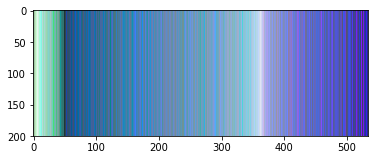

In [95]:
range_of_your_mom("faded blue",'colorname')

16032.802512983635

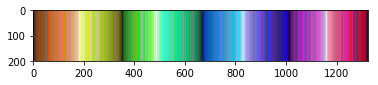

In [69]:
range_of_your_mom('penis','colorname',showrange=True)

5052.994834637973

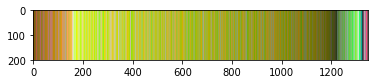

In [73]:
range_of_your_mom("vomit",'colorname',showrange=True)

8015.672054111783

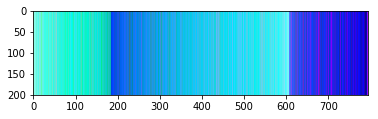

In [74]:
range_of_your_mom('neon blue','colorname',showrange=True)

In [100]:
color_variance("blue-grey",'colorname')

5557.117432210742

In [101]:
# using the "spam filter": Data rows are selected for each colorname and the variance of r,g,b values is calculated
# using the color_variance function and stored in the list "colorvar". Those names where variance is > 8000 are 
# shown and manually classified as spam or not.

import time #14.69 for 50 # 269.7 for 1000
start = time.process_time()
colorvar = []
for cnr, cname in enumerate(cnames_300):
    colorvar.append(color_variance(cname, 'colorname'))
    if cnr%100 == 0:
        print(f"{cnr} colornames of {len(cnames_300)} done.")
stop = time.process_time()
print(f"Elapsed time: {stop-start}")

0 colornames of 583 done.
100 colornames of 583 done.
200 colornames of 583 done.
300 colornames of 583 done.
400 colornames of 583 done.
500 colornames of 583 done.
Elapsed time: 138.670201


In [102]:
potential_spam_all = [cnames_300[i] for i in range(0,len(cnames_300)) if colorvar[i]>8000] 

In [103]:
potential_spam_all

['puce',
 'nigger',
 'ugly',
 'penis',
 'neon blue',
 'chartruse',
 'josh',
 'your mom',
 'gross',
 'shit',
 'aids',
 'muave',
 'watermelon',
 'vermillion',
 'marine',
 'gay',
 'asdf',
 'lightblue',
 'fuck',
 'tope',
 'yuck',
 'dunno']

In [104]:
spam_all = ['nigger','ugly','penis','josh','your mom','gross','shit','aids','gay','asdf','fuck','yuck','dunno']

In [105]:
df_nospam = df[~df['colorname'].isin(spam_all)]

In [106]:
sum(df['colorname'].isin(spam_all)) # 12532 spam rows removed

12532

In [107]:
df_nospam['colorname'].nunique()

570

### 3.4) Identifying misspelled words and assigning colornames to broader colorgroups
Levenshtein clustering is performed to assign colornames to broader groups. The Levenshtein distance quantifies how similar two words are (low value --> high similarity), it measures the minimum number of single-character edits necessary to change one word into the other. When performing levenshtein clustering, words which are similar are grouped together.
The results of the levenshtein clustering were manually checked and improved. In the end, 219 unique colornames (stored in the new column "colorcluster") remained and can be used for further analysis (e.g. predicting colornames for all values of the r,g,b space)

In [108]:
import nltk
from collections import Counter

In [109]:
unique_names = list(df_nospam['colorname'].value_counts().index) # spam already removed
#unique_names = list(unique_names[unique_names.values > 2].index)
len(unique_names)

570

In [110]:
import sklearn.cluster
import distance

def levenst(colorname,namelist,limit):
    levenst = [nltk.edit_distance(colorname,i) for i in namelist]
    similar = [i for i,x in enumerate(levenst) if x < limit]
    return [namelist[i] for i in similar]

def levenst_2words(colorname1,colorname2):
    levenst = nltk.edit_distance(colorname1,colorname2)
    return levenst

def levenst_clustering(dataframe,colname):
    """the levenshtein distance between colornames is calculated and used for clustering the words. This results 
    in groups of similar words (e.g. all the different spellings of fuchsia are grouped together)"""
    words = np.asarray(dataframe[colname].unique()) #So that indexing with a list will work
    lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])
    affprop = sklearn.cluster.AffinityPropagation(affinity='precomputed', damping=0.5, preference = -3)
    # the bigger the preference, the more clusters (i.e. the more similar words have to be to be added to same cluster)
    affprop.fit(lev_similarity)#
    cluster_centers = words[affprop.cluster_centers_indices_]
    res_levenst = pd.DataFrame(data = np.zeros((100,cluster_centers.shape[0])),columns=[cluster_centers])
    for cluster_id in np.unique(affprop.labels_):
        exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
        cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
        col = pd.Series(name=exemplar,data = list(cluster))
        res_levenst[exemplar] = col
        cluster_str = ", ".join(cluster)
        print(" - *%s:* %s" % (exemplar, cluster_str))
        dataframe.loc[dataframe[colname].isin(cluster),'colorcluster'] = exemplar
    return res_levenst

def apply_levenst_clustering(dataframe,colname,lev):
    """adding a new column colorcluster to the dataframe, which contains the name of the colorcluster each row belongs to"""
    dataframe['colorcluster'] = ""
    for clustername, series in lev.iteritems():
        dataframe.loc[dataframe[colname].isin(series),'colorcluster'] = clustername
    return dataframe

In [111]:
res_levenst = levenst_clustering(df_nospam,"colorname") # bei [0:500]: nunique = 120. without pref: reduced to 18
res_levenst.shape

 - *baby blue:* baby blue, dusty blue, gray blue, navy blue


/anaconda3/envs/neue-fische/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/neue-fische/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


 - *blue:* azure, blu, blue, blurple, plum
 - *light blue:* bright blue, light aqua, light blue, light mauve, lightblue, lighter blue, lightish blue
 - *brown:* bronze, brown
 - *black:* black, brick
 - *lime green:* lime green, olive green, pine green
 - *red brown:* grey brown, mud brown, red brown, red-brown
 - *teal:* peach, steel, tan, teal
 - *aubergine:* aubergine
 - *dark tan:* dark cyan, dark tan, dark teal
 - *magenta:* magenta
 - *goldenrod:* goldenrod
 - *purplish blue:* purpleish blue, purplish blue
 - *mustard:* mustard
 - *pale green:* apple green, pale brown, pale green, puke green
 - *cyan:* clay, cyan, ocean
 - *dark green:* dark brown, dark green, dark sea green, darker green, darkish green, dull green
 - *cornflower blue:* cornflower blue
 - *light purple:* bright purple, light purple, lighter purple
 - *dark orange:* dark orange, pale orange
 - *mauve:* mauve, muave, taupe
 - *khaki:* kaki, khaki
 - *mustard yellow:* mustard yellow
 - *sea blue:* gray-blue, mid blu

 - *bright sky blue:* bright sky blue, light sky blue
 - *ocre:* barf, ecru, ochre, ocre, olive
 - *very light green:* very light green
 - *kermit green:* forest green, kermit green
 - *purple pink:* purple pink, purple-pink, purplish pink
 - *olive brown:* olive brown
 - *dull pink:* dull pink, pale pink
 - *fucsia:* fuchia, fuchsia, fucsia, fusia
 - *apricot:* apricot
 - *very dark green:* very dark green
 - *silver:* silver
 - *yellowish brown:* yellowish brown, yellowish green
 - *amber:* adobe, amber, auburn, umber
 - *ultramarine:* ultramarine
 - *avocado:* avocado
 - *burnt red:* burnt red
 - *golden brown:* golden brown
 - *prussian blue:* prussian blue
 - *raspberry:* raspberry
 - *electric purple:* electric purple
 - *dusty purple:* dusty purple
 - *terracotta:* terra cotta, terracotta
 - *slate grey:* blue grey, slate gray, slate green, slate grey
 - *red violet:* red violet, red-violet
 - *lila:* aqua, lila, lilac, lime
 - *brownish orange:* brownish orange
 - *orchid:* orc

(100, 278)

In [112]:
# saving the levenshtein results:
# res_levenst.to_csv('../../data/colorsurvey/res_levenst_new.csv',index=False)

In [114]:
# loading the manually corrected res_levenst
res_levenst_modified = pd.read_csv('data/colorsurvey/res_levenst_modified.csv',sep=";")

In [115]:
res_levenst_modified.head()

,purple,black,navy blue,steel,orange,teal,aubergine,tan,moss green,magenta,...,british racing green,celery,light indigo,celadon,mulberry,eggshell,mahogany,maize,cerise,vermillion
0,blurple,black,navy blue,steel,orange,teal,aubergine,dark tan,moss green,magenta,...,british racing green,celery,light indigo,celadon,mulberry,eggshell,mahogany,maize,cerise,vermillion
1,pruple,NaN,navy,steel grey,dull orange,dark teal,NaN,tan,moss,dark magenta,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,puple,NaN,light navy blue,steel blue,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,purple,NaN,light navy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,purpleish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
df_nospam_levenst = apply_levenst_clustering(df_nospam,"colorname",res_levenst_modified)

/anaconda3/envs/neue-fische/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/neue-fische/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [117]:
print(df_nospam_levenst.head())

   id  user_id    r    g    b    colorname monitor  temperature  colorblind  \
0   1        1   72  100  175  pastel blue     LCD       6500.0         0.0   
2   3        1  182  226  245    baby blue     LCD       6500.0         0.0   
3   4        1  130   64  234       purple     LCD       6500.0         0.0   
4   5        2   75   49  234         blue     LCD       6500.0         0.0   
5   6        2   76  215  249   light blue     LCD       6500.0         0.0   

   ychrom colorcluster  
0     1.0  pastel blue  
2     1.0         blue  
3     1.0       purple  
4     1.0         blue  
5     1.0   light blue  


In [118]:
print(df_nospam_levenst['colorcluster'].nunique())

219


## DF export

In [73]:
# export df for further analysis in pycharm
#df_nospam_levenst.to_csv('../../data/colorsurvey/df_nospam_levenst.csv',index=False)